# Comparision of Machine Learning Methods vs Rule Based
* Traditionally, Educational Institutions use rule based models to generate risk score which then informs resource allocation. For example, *[Hiller et al, 1999](https://www.ets.org/Media/Research/pdf/RD_Connections18.pdf)*

* Instead, we'll build a simple model using basic ML techniques and demonstrate why the risk scores generated are better

In [175]:
## Imports
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Setup

* First, we need to generate simulated data and read it into a data frame

In [77]:
# Gen Data
%run sim.py

In [131]:
stud_df.gpa = pd.to_numeric(stud_df.gpa)
stud_df.honors = pd.to_numeric(stud_df.honors)
stud_df.psat = pd.to_numeric(stud_df.psat)

### Determine if the student undermatched-or-was-properly matched

In [125]:
avg_gpas = stud_df.groupby('college').gpa.mean()
def isUndermatched(student):
    if student.gpa >= (avg_gpas[student.college] + .50):
        return True
    else:
        return False

In [133]:
stud_df['undermatch_status'] = stud_df.apply(isUndermatched, axis =1 )
#stud_df.groupby('race').undermatch_status.value_counts()

## Rule Based Model 
* Simple GPA and PSAT rule

In [155]:
msk = np.random.rand(len(stud_df)) < 0.8
train = stud_df[msk]
test = stud_df[~msk]
print("Training Set Length: ", len(train))
print("Testing Set Length: ", len(test))

Training Set Length:  3151
Testing Set Length:  849


The Rules
* We have 3 observed variables - GPA, PSAT, race
* Predict which college based on those observed variables. 
* Rules based on *[Hoxby, et al 2013](http://www.brookings.edu/~/media/projects/bpea/spring-2013/2013a_hoxby.pdf)*

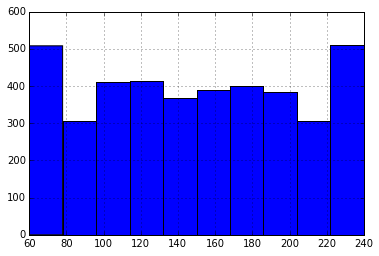

In [156]:
stud_df.psat.hist()

In [157]:
def rule_based_model(student_r): 
    """returns a college for each student passed"""
    risk_score = 0
    if student_r.race == 'aa':
        risk_score += 1
    if student_r.race == 'latino':
        risk_score += .5 
    if student_r.psat >= 170 and student_r.honors <= 3:
        risk_score += 1
    return risk_score

In [158]:
test['risk_score'] = test.apply(rule_based_model, axis = 1)

/Users/hunterowens/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Machine Learning Model

* Simple Logisitic Regression 

In [180]:
from sklearn import linear_model
feature_cols = ['psat', 'gpa', 'honors']
X = train[feature_cols]
y = train['undermatch_status']

# instantiate, fit
lm = linear_model.LinearRegression()
lm.fit(X, y)

/Users/hunterowens/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [182]:
# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((lm.predict(test[feature_cols]) - test['undermatch_status']) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(test[feature_cols], test['undermatch_status']))

Coefficients: 
 [-0.00286951  0.32139111 -0.00105851]
Residual sum of squares: 0.10
Variance score: 0.19


## Comparing Outputs